#Introduction

This is the notebook that i made as optional project for the course "Artificial Intelligence 2019/2020".
  
The idea behind this project was trying to replicate the varyous tecniques for text classification that we studied in class.

#Dependencies

In [8]:
import string
import sys
from google.colab import drive
import re

import pandas as pd
import numpy as np
import matplotlib.pylab as plt


from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from gensim.models import Word2Vec

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import keras
from keras import Sequential
from keras.layers import LSTM, Embedding, Dense, Activation, TimeDistributed

import gensim

# Downloading Data


All the experiments will be run on the famous "20 newsgroups" dataset.  

To reduce the otherwise long computing times necessary to obtain interesting results, all the experiments will be run only on a subset of the categories present on this dataset.

In [9]:
categories = ['alt.atheism', 'soc.religion.christian'] 
train_data = fetch_20newsgroups(subset='train', categories=categories)
test_data = fetch_20newsgroups(subset='test', categories=categories)

#Preprocessing

Connecting the notebook to a my drive account in order to acces some necessary files like the vocabulary.

In [10]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Preparing the vocabulary, the vocabulary defines the set of words that will be considered by the classifiers, all the words outside of this set will be ignored.

In [11]:
vocabulary_path="/content/drive/My Drive/Colab Notebooks/ia_project/google-10000-english.txt"
vocabulary_file=open(vocabulary_path,"r")
vocabulary_text = vocabulary_file.read()
vocabulary_file.close()
vocabulary_set=vocabulary_text.split()

Downloading and prepairing the stopwords set, a list of really common words that are not even worth being taken in consideration in a text classification task, because used too often in basically all kind of documents.

All the words contained inside this list will be completly ignored

In [12]:
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_set=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Defining a method **partition_data** which extracts the examples and the targets given a dataframe.



In [13]:
def extract(d, keys):
    return dict((k, d[k]) for k in keys if k in d)

def partition_data(data):
  data=extract(data,["data","target"])

  X=data['data']
  y=data['target']

  return X,y

We now define a **preprocess_X** method which given a list of documents executes the basic preprocessing. In particular this method executes the following operations on the document list given as input:
* removes from the documents all non alpha_numeric characters
* transforms each document (which is a single string) in a list of words.
* Removes from such list all words contained in the stopwords_set

In [14]:
def preprocess_X(X):
  X=[document.lower() for document in X]
  X=[re.sub(r'\W+', ' ', document) for document in X]
  X=[document.split() for document in X]
  X=[[w for w in document if not w in stopwords_set] for document in X]
  return X

Creating the training set and the test set.

In [15]:
train_X,train_y=partition_data(train_data)
test_X,test_y=partition_data(test_data)
print("Number of train examples: ", len(train_X))
print("Number of test exaples: ", len(test_X))

Number of train examples:  1079
Number of test exaples:  717


# Preparing Evaluation

We define a method that will be usefull to quickly evaluate the performance of each classifier that we will build in this notebook. We also save such informations in order to plot some graphics at the end of this notebook.  
All of the classifiers will be evaluated in terms of accuracy, precision and recall.

In [16]:
accuracy_results={}
precision_results={}
recall_results={}

In [17]:
def evaluate(y_test, y_pred, name=None):
  accuracy=accuracy_score(y_test, y_pred)
  precision=precision_score(y_test, y_pred, average='macro')
  recall=recall_score(y_test, y_pred, average='macro')

  if name is not None:
    accuracy_results[name]=accuracy
    precision_results[name]=precision
    recall_results[name]=recall


  print("accuracy:", accuracy)
  print("precision:", precision)
  print("recall:", recall)
  print("")

# Naive Bayes

I found no proper implementation online of nayve bayes so i made my own implementation by myself.

In [18]:
class NaiveBayes:
  class_priors={}
  likelihoods={}
  count_words={}
  vocabulary=[]

  def __init__(self,vocabulary, ngram=1):
    self.ngram=ngram
    self.vocabulary=vocabulary

  #Calculating the class priors
  #For each class we count the number of documents that have that class as target
  #Than we divide it by the number of total documents
  def calculate_class_priors(self,y):
    class_priors={}

    for document_classification in y:
      if document_classification not in class_priors:
        class_priors[document_classification]=0
      class_priors[document_classification]+=1

    for key in class_priors.keys():
      class_priors[key]/=len(y)

    return class_priors

  #Now we calculate the likelihoods of each word given the class
  def calculate_likelihoods(self,X,y):
    likelihoods={}
    count_words={}
    #We loop through all the documents and we count the number of occurencies of each
    #word given a class. We also count the total number of words of all documents
    #a given class
    for document_index in range(len(X)):
      sys.stdout.write("\r Examining document %i out of %i" % (document_index ,len(X)))
      sys.stdout.flush()
      document=X[document_index]
      target=y[document_index]
      if target not in likelihoods:
        likelihoods[target]={}
        likelihoods[target]["UNK"]=0
        count_words[target]=0
      for i in range(len(document)):
        word=document[i]
        if word not in likelihoods[target]:
          likelihoods[target][word]=0
        if word in self.vocabulary: 
          likelihoods[target][word]+=1
        else:
          likelihoods[target]["UNK"]+=1
        count_words[target]+=1
    for target in likelihoods:
      for word in likelihoods[target]:
        likelihoods[target][word]/=count_words[target]
    return likelihoods,count_words

  #Now the only thing that the train function has to do is invoking the 
  #previously defined functions to calculate the class priors and the 
  #word likelihoods
  def train(self,X,y):
    print("Preprocessing")
    X_pre=preprocess_X(X)
    print("Calculating Priors")
    self.class_priors=self.calculate_class_priors(y)
    print("Calculating likelihoods")
    self.likelihoods, self.count_words=self.calculate_likelihoods(X_pre,y)

  #We define a method which calculate the prediction for a single document
  def predict_single_document(self, document):
    best_class=None
    best_probability=None
    targets=self.likelihoods.keys()
    #We calculate the likelihood related to each possible classification, then
    #we return the prediction whith the highest likelihood
    for target in targets:
      current_probability=np.log(self.class_priors[target])
      #Calculating such probabilities can bring really easilly to underflows due to the really small moltiplicated between each other
      #To avoid this problem instead of moltiplicating the probabilities we can sum the logarithms of each of them
      #The logarithm is in fact a monothone function so the results of the optimization problem doesn't change 
      for word in document:
        #If the words are not present in the vocabulary we use the 
        #Also we use laplace smoothing to handle words contained in the vocabulary but that we never met during training
        if word in self.vocabulary:
          if word in self.likelihoods[target]:
            current_probability+=np.log(self.likelihoods[target][word])
          else:
            current_probability+=np.log(1/(self.count_words[target]+2))
        else:
          current_probability+=np.log(self.likelihoods[target]["UNK"])
      if best_probability==None or current_probability>best_probability:
        best_class=target
        best_probability=current_probability
    return best_class
    
  #Then we define a method which calculates a prediction for an array of documents
  def predict(self,X):
    X_pre=preprocess_X(X)
    predictions=[]
    print("Calculating predictions")
    for i,document in enumerate(X_pre):
      sys.stdout.write("\r Examining document %i out of %i" % (i ,len(X_pre)))
      sys.stdout.flush()
      prediction=self.predict_single_document(document)
      predictions.append(prediction)
    print("")
    return predictions


Now we can train our implementation

In [19]:
classifier=NaiveBayes(vocabulary_set,stopwords_set)
classifier.train(train_X,train_y)

Preprocessing
Calculating Priors
Calculating likelihoods
 Examining document 1078 out of 1079

And test it's performance

In [20]:
predictions=classifier.predict(test_X)
evaluate(test_y, predictions, "Naive Bayes")

Calculating predictions
 Examining document 716 out of 717
accuracy: 0.9205020920502092
precision: 0.9192389338784496
recall: 0.9199918085726437



# Machine Learning classification

With the machine learning approach we will try to train various types of classifiers with many different types of features.\\
In particular as classifiers i choes Support Vector Machines. I chose to use the sklearn implementation of such classifiers to execute the tests.

## Bag of Words

The CountVectorizer object of sklearn provides an implementation of an algorithm wich converts an array of documents into a bag of words representation

In [21]:
count_vect = CountVectorizer(vocabulary=vocabulary_set)
train_X_enc=count_vect.fit_transform(train_X)
test_X_enc=count_vect.transform(test_X)

Training and testing with a decision tree classifier

In [22]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(train_X_enc, train_y)
predictions=clf.predict(test_X_enc)
evaluate(test_y, predictions, "BOW Decision Tree")

accuracy: 0.8675034867503487
precision: 0.8746672582076309
recall: 0.8591862131976498



Training and testing with support vector machines as classifier

In [23]:
from sklearn import svm
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(train_X_enc, train_y)
predictions=clf.predict(test_X_enc)
evaluate(test_y, predictions, "BOW SVM")

accuracy: 0.8075313807531381
precision: 0.842913474327033
recall: 0.7883658102424347



## One Hot Encoding

Unfortunately i found no implementation of an one hot encoding so i built one myself. 
One hot encoding performed worse than bag of words. This is obvious since a one hot encoding carries much less information than a bag of word encoding.

In [24]:
def one_hot_vectorizer(X,vocabulary,stopwords_set):
  X_pre = preprocess_X(X)
  X_enc=[]
  for document in X_pre:
    word_counter=dict.fromkeys(vocabulary, 0)
    for word in document:
      if word in word_counter and word_counter[word]==0:
        word_counter[word]=1
    X_enc.append(list(word_counter.values()))
  return np.array(X_enc)


In [25]:
train_X_enc=one_hot_vectorizer(train_X, vocabulary_set, stopwords_set)
test_X_enc=one_hot_vectorizer(test_X, vocabulary_set, stopwords_set)

Training and testing with a decision tree classifier

In [26]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(train_X_enc, train_y)
predictions=clf.predict(test_X_enc)
evaluate(test_y, predictions, "One Hot Decision Tree")

accuracy: 0.8549511854951185
precision: 0.8567961555798829
recall: 0.8491241473826814



Training and testing with support vector machines as classifier

In [27]:
from sklearn import svm
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(train_X_enc, train_y)
predictions=clf.predict(test_X_enc)
evaluate(test_y, predictions, "One Hot SVM")

accuracy: 0.8856345885634589
precision: 0.9067552260323345
recall: 0.8733400545044974



## Word2Vec

I used the gensim implementation of word2vec to train a word2vec embedding. A word2vec embedding gives a vector representation for each word. Moreover i tested the classifier with both SkipGram and CBOW training of the word embedding.  
To get a vector representation of each document given the vector embeddings i chose to calculate the average sum of the embeddings of each one of his words.  
This approach didn't prove to be very effective, probably the use of recurrent neural networks would improve a lot the results.

In [28]:
embedding_dim=100

In [29]:
def w2v_encoding(X, w2v_model):
  X_enc=[]
  for document in X:
    document_enc=np.zeros(embedding_dim)
    n_valid_words=0
    for word in document:
      if word in w2v_model.wv.vocab:
        n_valid_words+=1
        document_enc+=w2v_model.wv[word]
    if n_valid_words!=0:
      document_enc/=n_valid_words
    X_enc.append(document_enc)
  return X_enc

In [30]:
train_X_pre=preprocess_X(train_X)
test_X_pre=preprocess_X(test_X)

In [31]:
corpus = fetch_20newsgroups()["data"]

### Skip *Gram*

In [32]:
w2v_model=gensim.models.Word2Vec(sentences=corpus, size=embedding_dim, window=5, workers=4, min_count=1, sg=1)

In [33]:
train_X_enc=w2v_encoding(train_X_pre, w2v_model)
test_X_enc=w2v_encoding(test_X_pre, w2v_model)

Training and testing with a decision tree classifier

In [34]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(train_X_enc, train_y)
predictions=clf.predict(test_X_enc)
evaluate(test_y, predictions, "Skip Gram Decision Tree")

accuracy: 0.6750348675034867
precision: 0.6812749941190308
recall: 0.6820859784817505



Training and testing with support vector machines as classifier

In [35]:
from sklearn import svm
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(train_X_enc, train_y)
predictions=clf.predict(test_X_enc)
evaluate(test_y, predictions, "Skip Gram SVM")

accuracy: 0.7308228730822873
precision: 0.7280197337860999
recall: 0.7242482002488934



### CBOW

In [36]:
w2v_model=gensim.models.Word2Vec(sentences=corpus, size=embedding_dim, window=5, workers=4, min_count=1, sg=0)

In [37]:
train_X_enc=w2v_encoding(train_X_pre, w2v_model)
test_X_enc=w2v_encoding(test_X_pre, w2v_model)

Training and testing with a decision tree classifier

In [38]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(train_X_enc, train_y)
predictions=clf.predict(test_X_enc)
evaluate(test_y, predictions, "CBOW Decision Tree")

accuracy: 0.705718270571827
precision: 0.707323719945185
recall: 0.7097241694365244



Training and testing with support vector machines as classifier

In [39]:
from sklearn import svm
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(train_X_enc, train_y)
predictions=clf.predict(test_X_enc)
evaluate(test_y, predictions, "CBOW SVM")

accuracy: 0.7224546722454672
precision: 0.7192172664166601
recall: 0.7163993950945953



## Doc2Vec

Gensim supports also a word embedding for entire documents instead of individual words. I trained one and tested it with the classifier. The results obtained with the support vector machine were decent but still worse than Naive Bayes and bag of words.

In [40]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

corpus_tag = [TaggedDocument(doc, [i]) for i, doc in enumerate(preprocess_X(corpus))]
d2v_model = Doc2Vec(corpus_tag, vector_size=embedding_dim, window=2, min_count=1, workers=4)

In [41]:
def d2v_encoding(X, d2v_model):
  X_pre=preprocess_X(X)
  X_enc=[]
  for document in X_pre:
    X_enc.append(d2v_model.infer_vector(document))
  return X_enc

In [42]:
train_X_enc=d2v_encoding(train_X,d2v_model)
test_X_enc=d2v_encoding(test_X,d2v_model)

Training and testing with a decision tree classifier

In [43]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(train_X_enc, train_y)
predictions=clf.predict(test_X_enc)
evaluate(test_y, predictions, "Doc2Vec Decision Tree")

accuracy: 0.6276150627615062
precision: 0.6219620202664964
recall: 0.6203942912052425



Training and testing with support vector machines as classifier

In [44]:
from sklearn import svm
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(train_X_enc, train_y)
predictions=clf.predict(test_X_enc)
evaluate(test_y, predictions, "Doc2Vec SVM")

accuracy: 0.7629009762900977
precision: 0.765256565121705
recall: 0.7525204391865282



# Conclusions

Below i plotted a diagram which shows the overall performances of all the experiments that i have made. We can easily see that naive bayes and decision three trained with bag of words were the classifiers that performed better

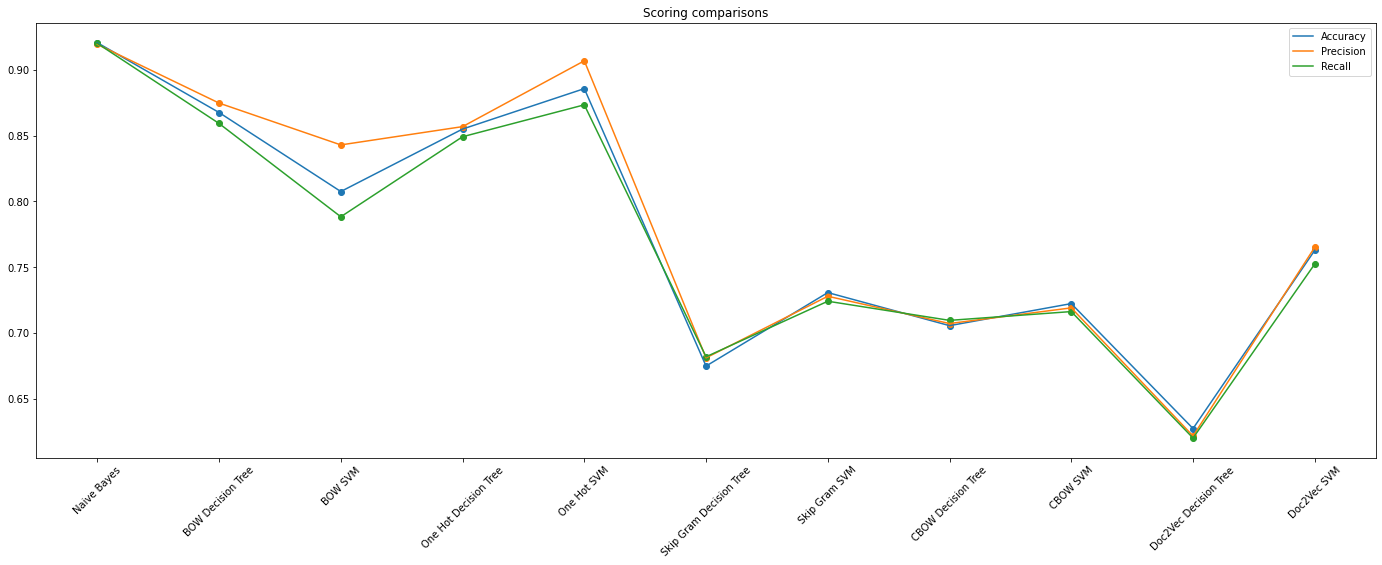

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=1)

fig.set_figwidth(24)
fig.set_figheight(8)

names=list(accuracy_results.keys())

ax.plot(names, list(accuracy_results.values()))
ax.scatter(names, list(accuracy_results.values()))

ax.plot(names, list(precision_results.values()))
ax.scatter(names, list(precision_results.values()))

ax.plot(names, list(recall_results.values()))
ax.scatter(names, list(recall_results.values()))

ax.set_xticklabels(list(names),rotation=45)
ax.set_title("Scoring comparisons")
ax.legend(["Accuracy","Precision","Recall"])

fig.show()

#Credits
Barzon Giacomo (1236597)